In [1]:
import os
import random
from dataclasses import dataclass
import pickle
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset, DatasetDict, Dataset
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments

import matplotlib.pyplot as plt

In [2]:
dataset = load_dataset("pandas", data_files="saved_pars/transformer_dataset.pkl")


Found cached dataset pandas (/users/felix.wagner/.cache/huggingface/datasets/pandas/default-6c4318920887342e/0.0.0/3ac4ffc4563c796122ef66899b9485a3f1a977553e2d2a8a318c72b8cc6f2202)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
@dataclass
class DecisionTransformerGymDataCollator:
    return_tensors: str = "pt"
    max_len: int = 20 #subsets of the episode we use for training
    state_dim: int = 17  # size of state space
    act_dim: int = 6  # size of action space
    max_ep_len: int = 1000 # max episode length in the dataset
    scale: float = 1000.0  # normalization of rewards/returns
    state_mean: np.array = None  # to store state means
    state_std: np.array = None  # to store state stds
    p_sample: np.array = None  # a distribution to take account trajectory lengths
    n_traj: int = 0 # to store the number of trajectories in the dataset

    def __init__(self, dataset) -> None:
        self.act_dim = len(dataset[0]["actions"][0])
        self.state_dim = len(dataset[0]["observations"][0])
        self.dataset = dataset
        # calculate dataset stats for normalization of states
        states = []
        traj_lens = []
        for obs in dataset["observations"]:
            states.extend(obs)
            traj_lens.append(len(obs))
        self.n_traj = len(traj_lens)
        states = np.vstack(states)
        self.state_mean, self.state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6
        
        traj_lens = np.array(traj_lens)
        self.p_sample = traj_lens / sum(traj_lens)

    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum

    def __call__(self, features):
        batch_size = len(features)
        # this is a bit of a hack to be able to sample of a non-uniform distribution
        batch_inds = np.random.choice(
            np.arange(self.n_traj),
            size=batch_size,
            replace=True,
            p=self.p_sample,  # reweights so we sample according to timesteps
        )
        # a batch of dataset features
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        
        for ind in batch_inds:
            # for feature in features:
            feature = self.dataset[int(ind)]
            si = random.randint(0, len(feature["rewards"]) - 1)

            # get sequences from dataset
            s.append(np.array(feature["observations"][si : si + self.max_len]).reshape(1, -1, self.state_dim))
            a.append(np.array(feature["actions"][si : si + self.max_len]).reshape(1, -1, self.act_dim))
            r.append(np.array(feature["rewards"][si : si + self.max_len]).reshape(1, -1, 1))

            d.append(np.array(feature["dones"][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            rtg.append(
                self._discount_cumsum(np.array(feature["rewards"][si:]), gamma=1.0)[
                    : s[-1].shape[1]   # TODO check the +1 removed here
                ].reshape(1, -1, 1)
            )
            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

            # padding and state + reward normalization
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            s[-1] = (s[-1] - self.state_mean) / self.state_std
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1) / self.scale
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))

        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()

        return {
            "states": s,
            "actions": a,
            "rewards": r,

            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
        }

In [4]:
class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, **kwargs):
        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output[1]
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        
        loss = torch.mean((action_preds - action_targets) ** 2)

        return {"loss": loss}

    def original_forward(self, **kwargs):
        return super().forward(**kwargs)

In [5]:
collator = DecisionTransformerGymDataCollator(dataset["train"])

In [6]:
config = DecisionTransformerConfig(state_dim=collator.state_dim, act_dim=collator.act_dim)
model = TrainableDT(config)

In [7]:
model = TrainableDT.from_pretrained('output/checkpoint-23500')

In [6]:
training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=120,
    per_device_train_batch_size=64,
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    data_collator=collator,
)

trainer.train()

Step,Training Loss
500,0.181900
1000,0.133400
1500,0.122200
2000,0.112300
2500,0.095200
3000,0.076800
3500,0.064800
4000,0.056100
4500,0.049300
5000,0.044200


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



TrainOutput(global_step=23640, training_loss=0.03745000237337426, metrics={'train_runtime': 2984.9662, 'train_samples_per_second': 506.538, 'train_steps_per_second': 7.92, 'total_flos': 651033936000000.0, 'train_loss': 0.03745000237337426, 'epoch': 120.0})

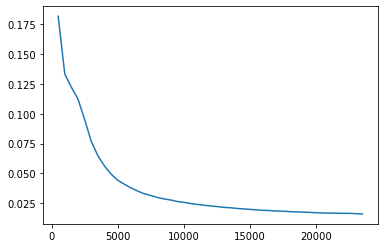

In [8]:
steps = np.array([500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 
                  5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 
                  10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 
                  15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 
                  19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500])

training_loss = np.array([0.1819, 0.1334, 0.1222, 0.1123, 0.0952, 0.0768, 
                          0.0648, 0.0561, 0.0493, 0.0442, 0.0408, 0.0378, 
                          0.0351, 0.0329, 0.0314, 0.0297, 0.0285, 0.0276, 
                          0.0263, 0.0256, 0.0246, 0.0239, 0.0232, 0.0226, 
                          0.0221, 0.0214, 0.0211, 0.0205, 0.0201, 0.0197, 
                          0.0193, 0.0189, 0.0187, 0.0183, 0.0182, 0.0178, 
                          0.0176, 0.0174, 0.0172, 0.0169, 0.0167, 0.0166, 
                          0.0165, 0.0164, 0.0164, 0.0161, 0.0159])

plt.plot(steps, training_loss)
plt.show()

# Inference

In [9]:
# Function that gets an action from the model using autoregressive prediction with a window of the previous 20 timesteps.
def get_action(model, states, actions, rewards, returns_to_go, timesteps):
    # This implementation does not condition on past rewards

    states = states.reshape(1, -1, model.config.state_dim)
    actions = actions.reshape(1, -1, model.config.act_dim)
    returns_to_go = returns_to_go.reshape(1, -1, 1)
    timesteps = timesteps.reshape(1, -1)

    states = states[:, -model.config.max_length :]
    actions = actions[:, -model.config.max_length :]
    returns_to_go = returns_to_go[:, -model.config.max_length :]
    timesteps = timesteps[:, -model.config.max_length :]
    padding = model.config.max_length - states.shape[1]
    # pad all tokens to sequence length
    attention_mask = torch.cat([torch.zeros(padding), torch.ones(states.shape[1])])
    attention_mask = attention_mask.to(dtype=torch.long).reshape(1, -1)
    states = torch.cat([torch.zeros((1, padding, model.config.state_dim)), states], dim=1).float()
    actions = torch.cat([torch.zeros((1, padding, model.config.act_dim)), actions], dim=1).float()
    returns_to_go = torch.cat([torch.zeros((1, padding, 1)), returns_to_go], dim=1).float()
    timesteps = torch.cat([torch.zeros((1, padding), dtype=torch.long), timesteps], dim=1)

    state_preds, action_preds, return_preds = model.original_forward(
        states=states,
        actions=actions,
        rewards=rewards,
        returns_to_go=returns_to_go,
        timesteps=timesteps,
        attention_mask=attention_mask,
        return_dict=False,
    )

    return action_preds[0, -1]

In [10]:
# build the environment

name_load = 'li2p'
version = '108'
rseed = int(version)
buffer_save_path = 'buffers_inf/'
buffer_size = 5200

In [11]:
with open("saved_pars/{}_pars_cryoenv.pkl".format(name_load),"rb") as fh:
    pars_load = pickle.load(fh)

In [12]:
from cryoenv.mqtt import augment_pars
import gymnasium as gym
from tqdm.auto import trange

In [13]:
tries = 0

while True:
    
    if tries > 10:
        raise AssertionError

    add_pars = {
        'store_raw': True,
        'max_buffer_len': buffer_size,
        'tpa_queue': [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'pileup_prob': 0.,
        'tp_interval': 10,
        'dac_range': (0., 5.), 
        'Ib_range': (0.5, 5.), 
        'adc_range': (-10., 10.),
        'rseed': rseed,
        'tau_cap': np.array([1.]),
                }

    np.random.seed(rseed)

    # pars_load = double_tes(pars_load)

    aug_pars = augment_pars(pars_load, **add_pars)
    # aug_pars = {**pars_load, **add_pars}

    env = gym.make('cryoenv:cryoenv-sig-v0',
                       omega=0.01,
                       log_reward=False,
                       rand_start=True,
                       relax_time=60,
                       tpa_in_state=True,
                       div_adc_by_bias=True,
                       pars=aug_pars,
                       render_mode='plotly',
                       rand_tpa=False,
                       )

    # check if transition is reachable

    env.detector.set_control(dac=np.ones(env.nheater), Ib=np.ones(env.ntes), norm=True)

    for i in range(10):
        env.detector.wait(5)

    try:
        for i in range(env.ntes):  # assumes TES are the first components!
            assert env.detector.Rt[i](env.detector.T[0,i]) > env.detector.Rs[i], 'transition of TES {} not reachable'.format(i)
        print('All transistions reachable, continuing')
        break
    except AssertionError:
        rseed *= 1000
        tries += 1
        print('Resampling parameters, new rseed: {}'.format(rseed))

/users/felix.wagner/.local/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


All transistions reachable, continuing


In [14]:
env.launch_display(title='Inference {} with {} TES'.format(name_load, env.ntes), 
                   color='red' if name_load == 'li1p' else 'turquoise' if name_load == 'li1l' else 'yellow' if name_load == 'li2p' else None)

FigureWidget({
    'data': [{'marker': {'color': 'yellow'},
              'mode': 'lines',
              'name…

In [15]:
model = model.to("cpu")
device = "cpu"

scale = 60.  # 1000.0  # normalization for rewards/returns
TARGET_RETURN = -3. # / scale  # 12000 / scale  # evaluation is conditioned on a return of 12000, scaled accordingly

state_mean = collator.state_mean.astype(np.float32)
state_std = collator.state_std.astype(np.float32)
print(state_mean)

state_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
# Create the decision transformer model

state_mean = torch.from_numpy(state_mean).to(device=device)
state_std = torch.from_numpy(state_std).to(device=device)

[-0.9973825  -0.99988246 -0.15172821 -0.37314853 -0.077825   -0.99470603]


In [16]:
episode_return, episode_length = 0, 0

state, _ = env.reset(clear_buffer=True)

target_return = torch.tensor(TARGET_RETURN, device=device, dtype=torch.float32).reshape(1, 1)
states = torch.from_numpy(state).reshape(1, state_dim).to(device=device, dtype=torch.float32)
actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
rewards = torch.zeros(0, device=device, dtype=torch.float32)

timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
for t in trange(60):
    actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
    rewards = torch.cat([rewards, torch.zeros(1, device=device)])
    
    action = get_action(
        model,
        (states - state_mean) / state_std,
        actions,
        rewards,
        target_return,
        timesteps,
    )
    actions[-1] = action
    action = action.detach().cpu().numpy()
    
    state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    
    # print(action, state, reward)
    
    cur_state = torch.from_numpy(state).to(device=device).reshape(1, state_dim)
    states = torch.cat([states, cur_state], dim=0)
    rewards[-1] = reward

    pred_return = target_return[0, -1] - (reward / scale)
    target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
    timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (t + 1)], dim=1)

    episode_return += reward
    episode_length += 1

    if done:
        break

/users/felix.wagner/.local/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:197: DeprecationWarning:

WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.

/users/felix.wagner/.local/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:210: DeprecationWarning:

WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.

/users/felix.wagner/.local/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

/users/felix.wagner/.local/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning:

WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actua

  0%|          | 0/60 [00:00<?, ?it/s]

/users/felix.wagner/.local/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning:

WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64

/users/felix.wagner/.local/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning:

WARN: The obs returned by the `step()` method is not within the observation space.

